In [1]:
%matplotlib inline
import os
import itertools

import yt
from yt.visualization.base_plot_types import get_multi_plot
import numpy as np
import unyt
import matplotlib.pyplot as plt

def _get_contained_dirs(path, full_entry_path = True):
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_dir():
                if full_entry_path:
                    yield entry.path
                else:
                    yield entry.name

In [2]:

def _momentum_radial(field, data, center = unyt.unyt_array([0.0, 0.0, 0.0], 'kpc'),
                     return_mask = False):

    delta_x = data['index', 'x'] - center[0]
    delta_y = data['index', 'y'] - center[1]
    delta_z = data['index', 'z'] - center[2]

    r_magnitude = np.sqrt(
        np.square(delta_x) + 
        np.square(delta_y) +
        np.square(delta_z)
    )

    out = (
        delta_x * data['cholla', 'momentum_x'] +
        delta_y * data['cholla', 'momentum_y'] +
        delta_z * data['cholla', 'momentum_z']
    ) / r_magnitude

    if return_mask:
        return out, (r_magnitude != 0.0)
    return out




class PropCalculator:

    def __init__(self, center_pos = unyt.unyt_array([0.0, 0.0, 0.0], 'kpc'),
                 mmw = 0.6, T_cut = 1e5 * unyt.K):
        self.center_pos = center_pos
        self.mmw = mmw
        self.T_cut = T_cut

    def __call__(self, ds):
        ad = ds.all_data()
        temperature = (
            self.mmw * unyt.mh * ad['gas', 'pressure'] /
            (ad['cholla', 'density'] * unyt.kboltz)
        ).to('K')

        w = (temperature >= self.T_cut)
        density_sum = ad['cholla', 'density'][w].sum()

        momentum, w_notnan = _momentum_radial(None, ad, center = self.center_pos,
                                              return_mask = True)
        total_radial_momentum_dens = momentum[w_notnan].sum()
        cell_vol = np.prod(ds.domain_width / ds.domain_dimensions)
        
        #print(total_radial_momentum_dens, cell_vol)
        out = {
            'total_momentum' : (total_radial_momentum_dens * cell_vol).to('Msun*km/s'),
            'total_hot_mass' : (density_sum * cell_vol).to('Msun'),
        }
        return out

calc_prop = PropCalculator()


In [3]:
ds = yt.load("/ix/eschneider/mabruzzo/hydro/SNe_tests/legacyUnresolved_offsets/logn1.0_1div7/160/160.h5.0")
#ds = yt.load("/ix/eschneider/mabruzzo/hydro/SNe_tests/resolvedCiC/logn-1.0/300/300.h5.0")
ds = yt.load("/ix/eschneider/mabruzzo/hydro/SNe_tests/tigress17noMassUnresolved_offsets/logn1.0_corner//160/160.h5.0")

yt : [INFO     ] 2024-05-07 00:40:41,793 Parameters: current_time              = [102.81583131]
yt : [INFO     ] 2024-05-07 00:40:41,793 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2024-05-07 00:40:41,794 Parameters: domain_left_edge          = [-0.18694196 -0.18694196 -0.18694196]
yt : [INFO     ] 2024-05-07 00:40:41,794 Parameters: domain_right_edge         = [0.18805804 0.18805804 0.18805804]
yt : [INFO     ] 2024-05-07 00:40:41,795 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-05-07 00:40:42,169 Parameters: current_time              = [102.81583131]
yt : [INFO     ] 2024-05-07 00:40:42,170 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2024-05-07 00:40:42,170 Parameters: domain_left_edge          = [-0.1875 -0.1875 -0.1875]
yt : [INFO     ] 2024-05-07 00:40:42,171 Parameters: domain_right_edge         = [0.1875 0.1875 0.1875]
yt : [INFO     ] 2024-05-07 00:40:42,171 Parameters: cosmological_simulation   = 0


/ix/eschneider/mabruzzo/envs-ondemand/py_310/lib/python3.10/site-packages/unyt/array.py:1906: RuntimeWarning: invalid value encountered in divide
  out_arr = func(
yt : [INFO     ] 2024-05-07 00:40:42,852 xlim = -0.187500 0.187500
yt : [INFO     ] 2024-05-07 00:40:42,852 ylim = -0.187500 0.187500
yt : [INFO     ] 2024-05-07 00:40:42,854 xlim = -0.187500 0.187500
yt : [INFO     ] 2024-05-07 00:40:42,854 ylim = -0.187500 0.187500
yt : [INFO     ] 2024-05-07 00:40:42,858 Making a fixed resolution buffer of (('gas', 'pressure')) 800 by 800
yt : [INFO     ] 2024-05-07 00:40:43,028 Making a fixed resolution buffer of (('cholla', 'momentum_density_radial')) 800 by 800
yt : [INFO     ] 2024-05-07 00:40:43,223 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2024-05-07 00:40:43,297 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



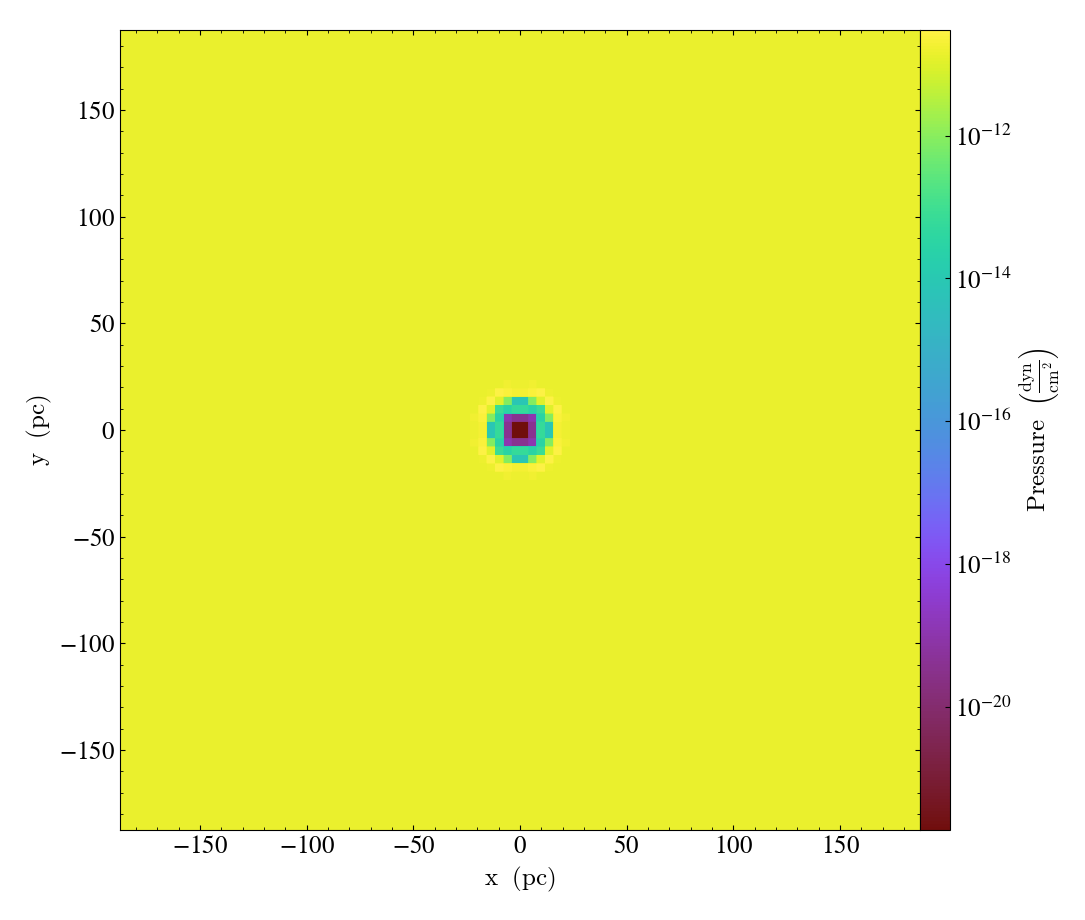
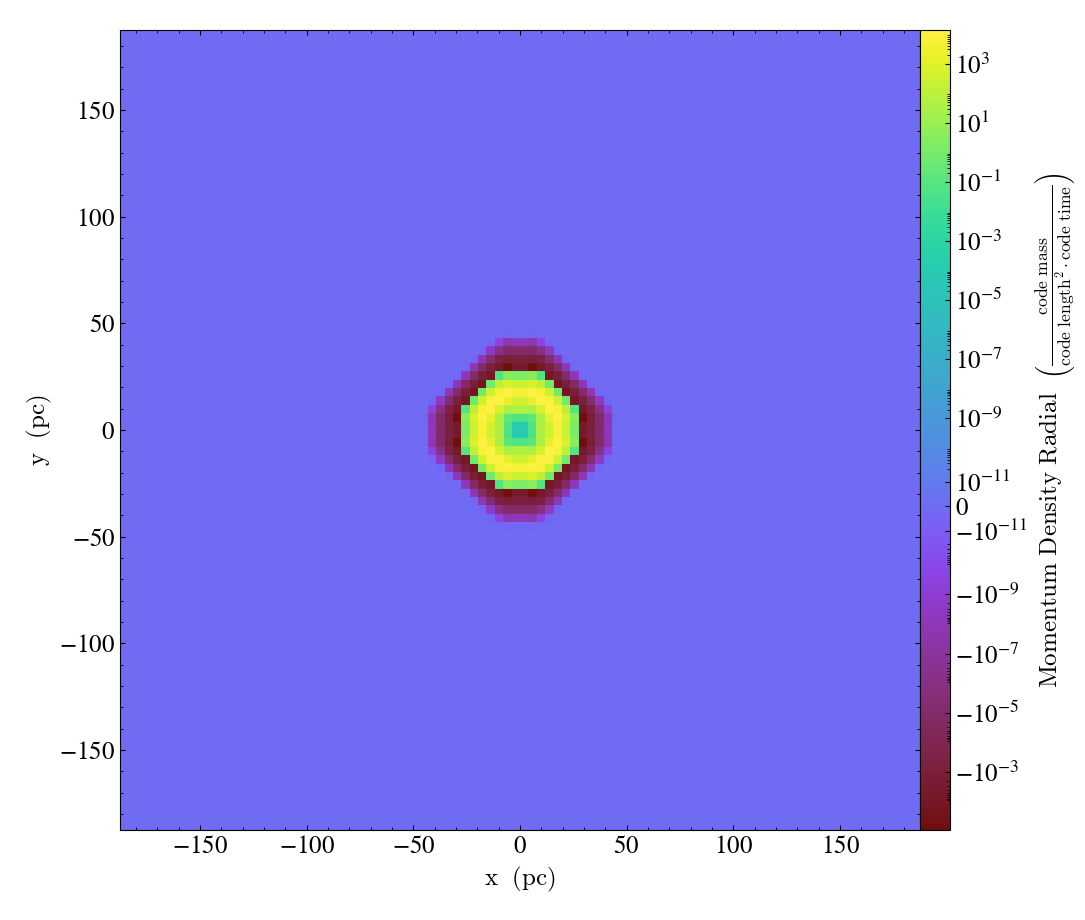
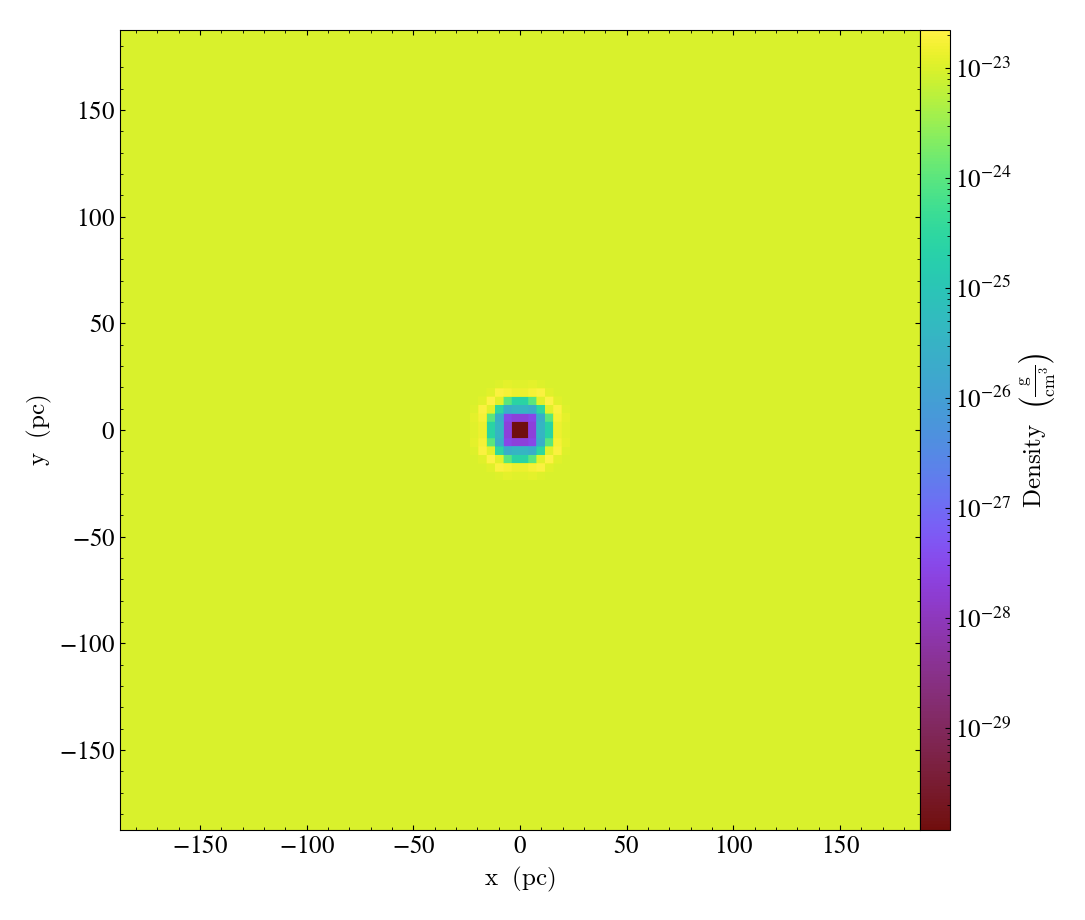
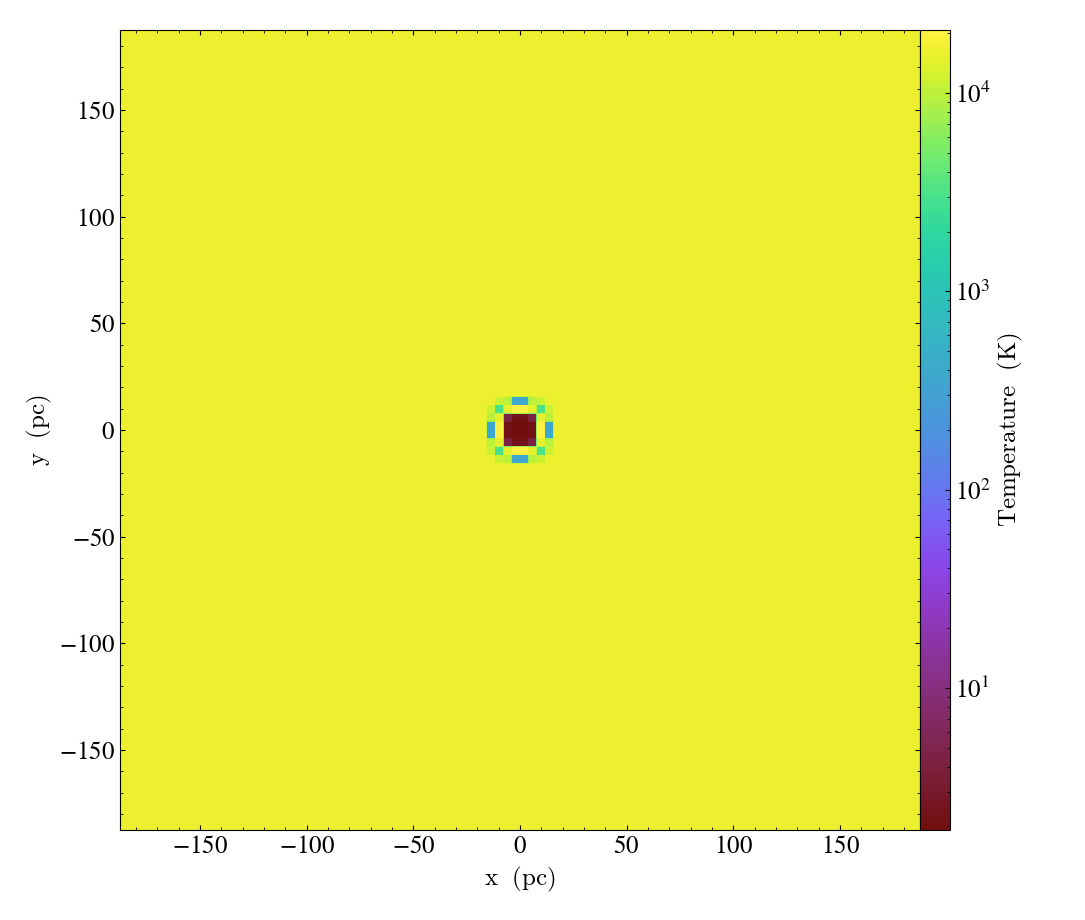

In [4]:
ds.add_field(('cholla', 'momentum_density_radial'),
             function = _momentum_radial,
             sampling_type = 'local',
             units = 'code_mass/code_length**2/code_time')

yt.SlicePlot(ds, 'z', fields = [('gas', 'density'), ('cholla', 'momentum_density_radial'),('gas', 'pressure'), ('gas', 'temperature')])

In [5]:
def _make_slice(ds, axis, coord, fields, slice_dims = None, width = None):    

    if slice_dims is None:
        assert (ds.domain_dimensions[0] == ds.domain_dimensions).all()
        slice_dims = [min(800,ds.domain_dimensions[0]) for i in range(2)]

    if width is None:
        assert (ds.domain_width[0] == ds.domain_width).all()
        width = (float(ds.domain_width.ndview[0]), str(ds.domain_width.units))

    slc = ds.slice(axis, coord)
    frb = slc.to_frb(width = width, resolution = slice_dims,
                     center = None, periodic = False)

    out = {
        field : frb[field] for field in fields
    }
    return out


tmp = _make_slice(ds, 'z', coord = 0.0, fields = [('cholla', 'density'), ('gas', 'pressure')])

yt : [INFO     ] 2024-05-07 00:40:46,292 Making a fixed resolution buffer of (('cholla', 'density')) 96 by 96
yt : [INFO     ] 2024-05-07 00:40:46,318 Making a fixed resolution buffer of (('gas', 'pressure')) 96 by 96


In [6]:
tmp.to_frb?

Object `tmp.to_frb` not found.


In [7]:
import os, shutil
import dataclasses
from typing import Union, Tuple

@dataclasses.dataclass
class AmbientICs:
    ndens_cgs: float
    T_Kelvin: float
    mmw: float = 0.6

    def calc_rho_P_codeU(self):
        kboltz_cgs = 1.3806488e-16
        mh_cgs = 1.67373522e-24

        pressure_cgs = self.ndens_cgs * self.T_Kelvin * kboltz_cgs
        mass_density_cgs = self.ndens_cgs * self.mmw * mh_cgs

        rho_code = mass_density_cgs / 6.767925712378866e-32
        pressure_code = pressure_cgs / 6.470662364627876e-10

        return rho_code, pressure_code

    def nominal_tsf_kyr(self):
        # computes the nominal shell-formation time in a uniform medium in keyr
        # uses equation 22 from Kim & Ostriker (2015)
        return 40.0 * (self.ndens_cgs**-0.59)

@dataclasses.dataclass(frozen = True)
class SimProperties:
    sn_model: str
    ic: AmbientICs
    sim_dir: str

    outdir: str = "./"
    output_cadence_kyr: Union[float,str] = 4.0
    tfinal_kyr: Union[float,str] = 1200 
    width_kpc: float = 0.375
    n_cells: int = 96
    cell_edge_offset : Tuple[float, float, float] = (0.0, 0.0, 0.0)

    def __post_init__(self):
        assert len(self.cell_edge_offset) == 3
        assert 0.0 <= self.cell_edge_offset[0] < 1
        assert 0.0 <= self.cell_edge_offset[1] < 1
        assert 0.0 <= self.cell_edge_offset[2] < 1

    def min_domain_vals(self):
        out = {}
        for i,axis in enumerate("xyz"):
            cur_offset = self.cell_edge_offset[i]
            if cur_offset < 0.5:
                left = (-0.5 + (cur_offset/self.n_cells) ) * self.width_kpc
            else:
                left = (-0.5 + ((1-cur_offset)/self.n_cells) ) * self.width_kpc
            out[f'{axis}min'] = left
        return out

    @property
    def sim_name(self):
        return os.path.basename(self.sim_dir)

_template = """\
#
# Parameter File for an isolated star. 
#
######################################
# number of grid cells in the x dimension
nx={n_cells}
# number of grid cells in the y dimension
ny={n_cells}
# number of grid cells in the z dimension
nz={n_cells}
# final output time
tout={tfinal_kyr}
# time interval for output
outstep={output_cadence_kyr}
n_hydro=1
# value of gamma
gamma=1.66666667
# name of initial conditions
init=Isolated_Stellar_Cluster

feedback_sn_model={sn_model}
feedback_sn_rate=immediate_sn
feedback_boundary_strategy=snap
snr_filename=
sw_filename=./src/feedback/starburst99_sw.txt
bc_potential_type=1
# domain properties
xmin={xmin}
ymin={ymin}
zmin={zmin}
xlen={width_kpc}
ylen={width_kpc}
zlen={width_kpc}
# background properties

rho={rho}
P={pressure} 
vx=0
vy=0
vz=0

# type of boundary conditions
xl_bcnd=1
xu_bcnd=1
yl_bcnd=1
yu_bcnd=1
zl_bcnd=1
zu_bcnd=1
# path to output directory
outdir={outdir}
prng_seed=41
"""

def setup_sim(binary_path, sim_props):
    os.makedirs(sim_props.sim_dir, exist_ok=True)

    binary_basename = os.path.basename(binary_path)
    
    shutil.copyfile(
        binary_path,
        f'{sim_props.sim_dir}/{binary_basename}'
    )
    shutil.copymode(
        binary_path,
        f'{sim_props.sim_dir}/{binary_basename}'
    )

    param_file = f'{sim_props.sim_dir}/config.txt'
    run_script = f'{sim_props.sim_dir}/run_sim.sh'

    rho, pressure = sim_props.ic.calc_rho_P_codeU()

    min_domain_vals = sim_props.min_domain_vals()

    with open(param_file, 'w') as f:
        f.write(_template.format(
            n_cells = sim_props.n_cells,
            tfinal_kyr = sim_props.tfinal_kyr,
            output_cadence_kyr = sim_props.output_cadence_kyr,
            sn_model = sim_props.sn_model,
            width_kpc = sim_props.width_kpc,
            rho = rho,
            pressure = pressure,
            outdir = sim_props.outdir,
            xmin = min_domain_vals['xmin'],
            ymin = min_domain_vals['ymin'],
            zmin = min_domain_vals['zmin'],
        ))

    with open(run_script, 'w') as f:
        f.write(r'#!/usr/bin/env bash' + '\n')
        f.write('\n# this must be executed when in the same dir as this script\n')
        f.write(f'./{binary_basename} {os.path.basename(param_file)}\n')


In [8]:
_RUN_ALL_FILE="""

import contextlib
import os
import subprocess

_TIMEOUT = 30 * 60 # half an hour

def _get_contained_dirs(path, full_entry_path = True):
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_dir():
                if full_entry_path:
                    yield entry.path
                else:
                    yield entry.name

def _make_dummy_file(path):
    with open(path, 'w') as f:
        f.write('.\\n')

def _process(sim_dir):
    print(f"RUNNING {sim_dir}")
    if os.path.isfile(f'{sim_dir}/LAUNCHED'):
        print(f"{sim_dir} already launched! SKIPPING.")
        return None
    _make_dummy_file(f'{sim_dir}/LAUNCHED')

    with contextlib.ExitStack() as stack:
        f_err = stack.enter_context(open(f'{sim_dir}/log.err', 'w+'))
        f_out = stack.enter_context(open(f'{sim_dir}/log.out', 'w+'))
        try:
            subprocess.run(
                f"bash run_sim.sh",
                timeout = _TIMEOUT,
                close_fds = True,
                check = True,
                shell = True, cwd = sim_dir,
                stderr = f_err, stdout = f_out
            )
            _make_dummy_file(f'{sim_dir}/SIM_DONE')
        except subprocess.TimeoutExpired:
            _make_dummy_file(f'{sim_dir}/TIMEOUT')
        except subprocess.CalledProcessError:
            _make_dummy_file(f'{sim_dir}/ERROR')
        except:
            raise
        finally:
            print('done with attempt\\n\\n')

_CUR_DIR = os.path.dirname(os.path.abspath(__file__))
_SIM_DIRS = []
for sim_dir in  _get_contained_dirs(_CUR_DIR, full_entry_path = True):
    if os.path.basename(sim_dir) == 'summary':
        continue
    _SIM_DIRS.append(sim_dir)

for sim_dir in _SIM_DIRS:
    _process(sim_dir)
"""

_ROOT_DIR = '/ix/eschneider/mabruzzo/hydro/SNe_tests/'

def _get_contained_dirs(path, full_entry_path = True):
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_dir():
                if full_entry_path:
                    yield entry.path
                else:
                    yield entry.name

def make_runall_scripts(root_outdir = _ROOT_DIR):
    for collection_dir in _get_contained_dirs(root_outdir):
        with open(f'{collection_dir}/run_all.py', 'w') as f:
            sim_dir_l = []
            for sim_dir in _get_contained_dirs(collection_dir):
                if os.path.basename(sim_dir) == 'summary':
                    continue
                sim_dir_l.append(sim_dir)
            f.write(_RUN_ALL_FILE)

In [9]:
_BINARY_PATH = '/ix/eschneider/mabruzzo/hydro/SNe_tests/cholla.starblast2.crc'


def build_simulations(root_outdir, sn_model, triples, family = None):
    if family is None:
        family = sn_model
    for name, ndens_cgs, cell_edge_offset in triples:
        ic = AmbientICs(ndens_cgs = ndens_cgs, T_Kelvin = 1e4)
        nominal_tsf_kyr = ic.nominal_tsf_kyr()
        output_cadence_kyr = nominal_tsf_kyr/16.0
        tfinal_kyr = 10.0 * nominal_tsf_kyr
        sim_props = SimProperties(
            sn_model = sn_model, ic = ic,
            sim_dir = f'{root_outdir}/{family}/{name}/',
            output_cadence_kyr = output_cadence_kyr,
            tfinal_kyr = tfinal_kyr,
            cell_edge_offset = cell_edge_offset
        )
        yield sim_props

def get_first_wave_sims(sn_model):

    log10_n_vals = [-1.0, -0.5, 0.0, 0.25, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25]

    cornerAligned_name_ndens_edgeOffset_triples = []
    for e in log10_n_vals:
        cornerAligned_name_ndens_edgeOffset_triples.append(
            (f'logn{e!r}', 10.0**e, (0.0,0.0,0.0) )
        )

    return list(
        build_simulations(
            root_outdir = _ROOT_DIR,
            sn_model = sn_model,
            triples = cornerAligned_name_ndens_edgeOffset_triples
        )
    )

resolved_sims = get_first_wave_sims("resolvedCiC")
legacy_fb_sims = get_first_wave_sims("legacy")
resolved27cell_fb_sims = get_first_wave_sims("resolved27cell")


def varying_offset_sims(sn_model, log10_n_val, family_prefix):
    
    name_prefix = f'logn{log10_n_val!r}'
    triples = [
        (f'{name_prefix}_corner', 10.0**log10_n_val, (0.0, 0.0, 0.0)),
        (f'{name_prefix}_center', 10.0**log10_n_val, (0.5, 0.5, 0.5)),
        (f'{name_prefix}_1div7', 10.0**log10_n_val, (1./7, 1./7, 1./7)),
        (f'{name_prefix}_2div7', 10.0**log10_n_val, (2./7, 2./7, 2./7)),
        (f'{name_prefix}_3div7', 10.0**log10_n_val, (3./7, 3./7, 3./7)),
        (f'{name_prefix}_staggered', 10.0**log10_n_val, (1./7, 2./7, 3./7)),
    ]

    return list(
        build_simulations(
            root_outdir = _ROOT_DIR,
            sn_model = sn_model,
            triples = triples,
            family = f'{family_prefix}_offsets'
        )
    )

resolvedOffset_sims = varying_offset_sims(sn_model = "resolvedCiC", 
                                          log10_n_val = 0.0,
                                          family_prefix = "resolvedCiC")
resolved27cell_sims = varying_offset_sims(sn_model = "resolved27cell", 
                                          log10_n_val = 0.0,
                                          family_prefix = "resolved27cell")
legacyUnresolvedOffset_sims = varying_offset_sims(sn_model = "legacy", 
                                                  log10_n_val = 1.0,
                                                  family_prefix = "legacyUnresolved")
tigress17withMassUnresolvedOffset_sims = varying_offset_sims(
    sn_model = "resolvedCiC_UnresolvedTIGRESS17withMass", 
    log10_n_val = 1.0,
    family_prefix = "tigress17withMassUnresolved"
)

tigress17UnresolvedOffset_sims = varying_offset_sims(
    sn_model = "resolvedCiC_UnresolvedTIGRESS17", 
    log10_n_val = 1.0,
    family_prefix = "tigress17noMassUnresolved"
)

legacyAltUnresolvedOffset_sims = varying_offset_sims(
    sn_model = "legacyAlt", 
    log10_n_val = 1.0,
    family_prefix = "legacyAltUnresolved"
)

if True:
    for sim_props in (resolved27cell_sims+tigress17withMassUnresolvedOffset_sims+
                      tigress17UnresolvedOffset_sims + legacyAltUnresolvedOffset_sims):
        print(sim_props)
        setup_sim(_BINARY_PATH, sim_props)

if True:
    make_runall_scripts()

SimProperties(sn_model='resolved27cell', ic=AmbientICs(ndens_cgs=1.0, T_Kelvin=10000.0, mmw=0.6), sim_dir='/ix/eschneider/mabruzzo/hydro/SNe_tests//resolved27cell_offsets/logn0.0_corner/', outdir='./', output_cadence_kyr=2.5, tfinal_kyr=400.0, width_kpc=0.375, n_cells=96, cell_edge_offset=(0.0, 0.0, 0.0))
SimProperties(sn_model='resolved27cell', ic=AmbientICs(ndens_cgs=1.0, T_Kelvin=10000.0, mmw=0.6), sim_dir='/ix/eschneider/mabruzzo/hydro/SNe_tests//resolved27cell_offsets/logn0.0_center/', outdir='./', output_cadence_kyr=2.5, tfinal_kyr=400.0, width_kpc=0.375, n_cells=96, cell_edge_offset=(0.5, 0.5, 0.5))
SimProperties(sn_model='resolved27cell', ic=AmbientICs(ndens_cgs=1.0, T_Kelvin=10000.0, mmw=0.6), sim_dir='/ix/eschneider/mabruzzo/hydro/SNe_tests//resolved27cell_offsets/logn0.0_1div7/', outdir='./', output_cadence_kyr=2.5, tfinal_kyr=400.0, width_kpc=0.375, n_cells=96, cell_edge_offset=(0.14285714285714285, 0.14285714285714285, 0.14285714285714285))
SimProperties(sn_model='resolved

In [10]:

def process_props(simdir, snaps = None):
    if snaps is None:
        snaps = sorted(
            int(e) for e in _get_contained_dirs(simdir, False)
        )

    out = {'t' : []}
    for i in snaps:
        ds = yt.load(f'{simdir}/{i}/{i}.h5.0')
        tmp = calc_prop(ds)
        out['t'].append(ds.current_time.to('kyr').flatten()[0])

        for key in tmp:
            if key not in out:
                out[key] = []
            out[key].append(tmp[key])

    for key in out:
        out[key] = unyt.unyt_array(out[key])
    return out


def postprocess_data(path, just_load = False, snaps = None):
    summary_dir = f'{path}/summary'
    os.makedirs(summary_dir, exist_ok = True)

    out = {}

    for sim_name in _get_contained_dirs(path, False):
        if sim_name == 'summary':
            continue
        print('\n')
        simdir = f'{path}/{sim_name}'
        summary_file = f'{summary_dir}/{sim_name}.h5'
        print(simdir,summary_file)
        if os.path.isfile(summary_file):
            print(f'loading {sim_name}')
            tmp = yt.load(summary_file)
            out[sim_name] = dict(
                (field[1],tmp.data[field]) for field in tmp.field_list
            )
        elif not just_load:
            print(f'analyzing {sim_name}')
            tmp = process_props(simdir, snaps = snaps)
            yt.save_as_dataset(ds = {}, filename = summary_file,
                               data = tmp)
            out[sim_name] = tmp
        else:
            print(f'skipping {sim_name}')

    return out


first_wave_families = ['legacy', 'resolvedCiC', 'resolved27cell']

offset_families = ['resolvedCiC_offsets', 'legacyUnresolved_offsets', 'tigress17noMassUnresolved_offsets', "tigress17withMassUnresolved_offsets",
                   "legacyAltUnresolved_offsets", "resolved27cell_offsets"]

processed = {}

for family in offset_families:
    print(family)
    processed[family] = postprocess_data(f'/ix/eschneider/mabruzzo/hydro/SNe_tests/{family}',
                                         just_load = False, snaps = None)

resolvedCiC_offsets


/ix/eschneider/mabruzzo/hydro/SNe_tests/resolvedCiC_offsets/logn0.0_corner /ix/eschneider/mabruzzo/hydro/SNe_tests/resolvedCiC_offsets/summary/logn0.0_corner.h5
loading logn0.0_corner


yt : [WARNING  ] 2024-05-07 00:40:47,509 Geometric data selection not available for this dataset type.




/ix/eschneider/mabruzzo/hydro/SNe_tests/resolvedCiC_offsets/logn0.0_2div7 /ix/eschneider/mabruzzo/hydro/SNe_tests/resolvedCiC_offsets/summary/logn0.0_2div7.h5
loading logn0.0_2div7


/ix/eschneider/mabruzzo/hydro/SNe_tests/resolvedCiC_offsets/logn0.0_3div7 /ix/eschneider/mabruzzo/hydro/SNe_tests/resolvedCiC_offsets/summary/logn0.0_3div7.h5
loading logn0.0_3div7


/ix/eschneider/mabruzzo/hydro/SNe_tests/resolvedCiC_offsets/logn0.0_1div7 /ix/eschneider/mabruzzo/hydro/SNe_tests/resolvedCiC_offsets/summary/logn0.0_1div7.h5
loading logn0.0_1div7


/ix/eschneider/mabruzzo/hydro/SNe_tests/resolvedCiC_offsets/logn0.0_staggered /ix/eschneider/mabruzzo/hydro/SNe_tests/resolvedCiC_offsets/summary/logn0.0_staggered.h5
loading logn0.0_staggered


/ix/eschneider/mabruzzo/hydro/SNe_tests/resolvedCiC_offsets/logn0.0_center /ix/eschneider/mabruzzo/hydro/SNe_tests/resolvedCiC_offsets/summary/logn0.0_center.h5
loading logn0.0_center
legacyUnresolved_offsets


/ix/eschneider/mabruzzo/hydro/SNe_tests/leg

(0.0, 20.0)

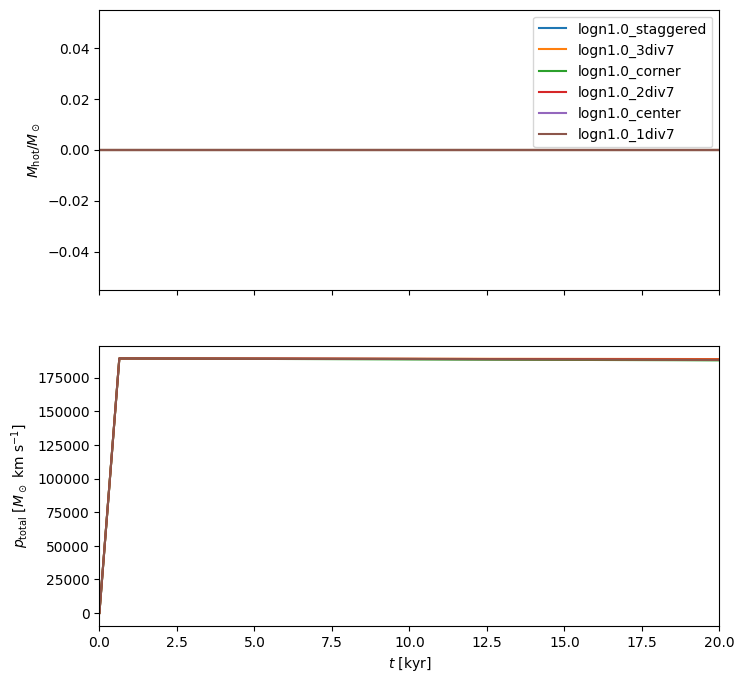

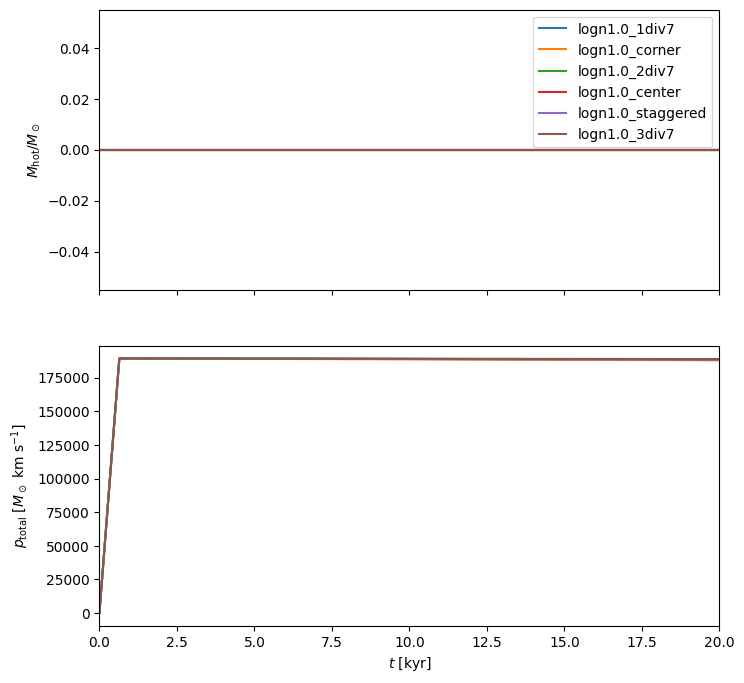

In [14]:


def compare_time_series(ax, pairs, key, **kwargs):
    for (sim_name, sim_ts) in pairs:
        ax.plot(sim_ts['t'].ndview, sim_ts[key].ndview, label = sim_name,
                **kwargs)

def primary_time_series(pairs):
    fig, ax_arr = plt.subplots(2,1, sharex = True, figsize = (8,8))

    ax_arr[0].set_ylabel(r'$M_{\rm hot}/M_\odot$')
    compare_time_series(ax_arr[0], pairs, 'total_hot_mass')
    ax_arr[0].legend()

    ax_arr[1].set_ylabel(r'$p_{\rm total}\ [M_\odot\ {\rm km}\ {\rm s}^{-1}]$')
    compare_time_series(ax_arr[1], pairs, 'total_momentum')

    ax_arr[1].set_xlabel(r'$t\ [{\rm kyr}]$')

    return fig, ax_arr

_, ax_arr = primary_time_series(
    sorted(processed['tigress17noMassUnresolved_offsets'].items(),
           key=lambda kv_pair: float(kv_pair[0].split('_')[0][4:]))
)

ax_arr[0].set_xlim(0,20)

_, ax_arr = primary_time_series(
    sorted(processed['tigress17withMassUnresolved_offsets'].items(),
           key=lambda kv_pair: float(kv_pair[0].split('_')[0][4:]))
)

ax_arr[0].set_xlim(0,20)

In [28]:
first_wave_families = ['legacy', 'resolvedCiC', 'resolved27cell']

offset_families = ['resolvedCiC_offsets', 'legacyUnresolved_offsets', 'tigress17noMassUnresolved_offsets', "tigress17withMassUnresolved_offsets",
                   "legacyAltUnresolved_offsets", "resolved27cell_offsets"]

processed = {}

for family in first_wave_families+offset_families:
    print(family)
    processed[family] = postprocess_data(f'/ix/eschneider/mabruzzo/hydro/SNe_tests/{family}',
                                         just_load = False, snaps = None)

legacy


/ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/logn0.25 /ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/summary/logn0.25.h5
loading logn0.25


/ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/logn-0.5 /ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/summary/logn-0.5.h5
loading logn-0.5


/ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/logn0.875 /ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/summary/logn0.875.h5
loading logn0.875


/ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/logn0.625 /ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/summary/logn0.625.h5
loading logn0.625


/ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/logn0.0 /ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/summary/logn0.0.h5
loading logn0.0


/ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/logn1.0 /ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/summary/logn1.0.h5
loading logn1.0


/ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/logn0.5 /ix/eschneider/mabruzzo/hydro/SNe_tests/legacy/summary/logn0.5.h5
loading logn0.5




(0.0, 150.0)

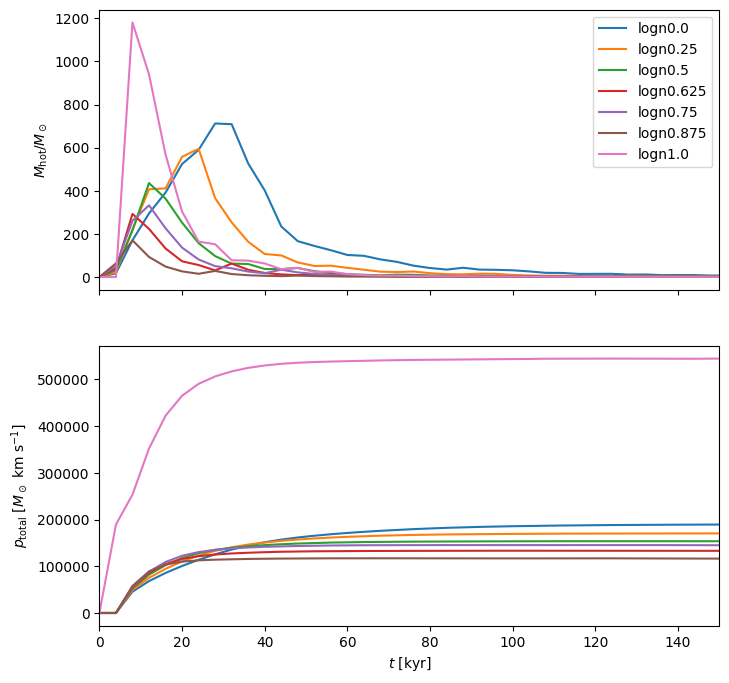

In [33]:
_, ax_arr = primary_time_series(
    sorted(processed['legacy'].items(),
           key=lambda kv_pair: float(kv_pair[0].split('_')[0][4:]))[2:]
)

ax_arr[0].set_xlim(0,150)

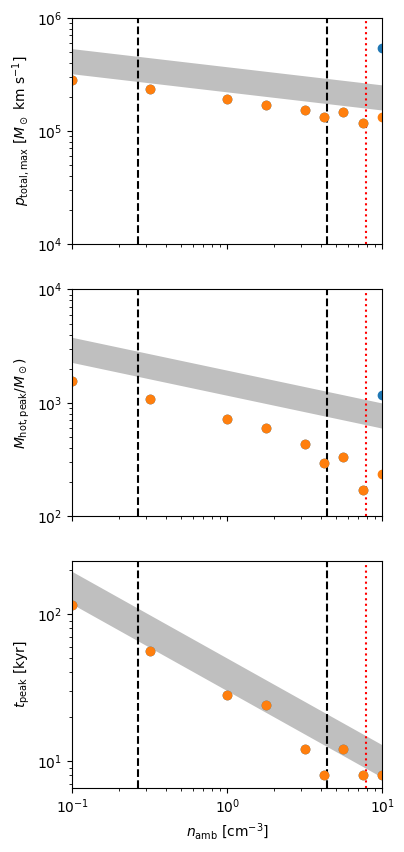

In [30]:
def _get_reduced_points(pairs):
    d = dict(
        n_vals = [],
        Mhot_peak = [],
        p_max = [],
        t_peak = []
    )

    for name, time_series_dict in pairs:
        d['n_vals'].append(
            unyt.unyt_quantity(10.0**float(name[4:]), 'cm**-3')
        )

        ind = np.argmax(time_series_dict['total_hot_mass'])
        d['Mhot_peak'].append(time_series_dict['total_hot_mass'][ind])
        d['t_peak'].append(time_series_dict['t'][ind])
        d['p_max'].append(time_series_dict['total_momentum'].max())

    for k in d.keys():
        d[k] = unyt.unyt_array(d[k])
    return d

print()


def plot_reduced_points(pairs,ax_arr = None):

    d = _get_reduced_points(pairs)

    for i,(ylabel, ykey) in enumerate([(r'$p_{\rm total,max}\ [M_\odot\ {\rm km}\ {\rm s}^{-1}]$',
                                        'p_max'),
                                       (r'$M_{\rm hot,peak}/M_\odot)$', 'Mhot_peak'),
                                       (r'$t_{\rm peak}\ [{\rm kyr}]$', 't_peak'),
                                       ]
                                     ):
        ax_arr[i].set_ylabel(ylabel)
        x = d['n_vals'].ndview
        y = d[ykey].ndview
        #print(x,y)
        ax_arr[i].plot(x, y, ls = '', marker = 'o')

    ax_arr[-1].set_xlabel(r'$n_{\rm amb}\ [{\rm cm}^{-3}]$')


def full_reduced_plot(cell_width = 1.0/256):
    fig, ax_arr = plt.subplots(3,1, sharex = True, figsize = (4,10))

    expected_namb_cgs = np.array([0.1,10.0])
    expected_pfinal = 2.95e5 * (expected_namb_cgs**-0.16)
    expected_Mhpeak = 1.55e3 * (expected_namb_cgs**-0.29)
    expected_tpeak_kyr = 40. * (expected_namb_cgs**-0.59)

    fill_bt_kwargs = dict(color = 'gray', alpha = 0.5, lw = 0)

    ax_arr[0].fill_between(expected_namb_cgs, 0.75 * expected_pfinal,
                           1.25 * expected_pfinal,
                           **fill_bt_kwargs)
    ax_arr[1].fill_between(expected_namb_cgs, 0.75 * expected_Mhpeak,
                           1.25 * expected_Mhpeak,
                           **fill_bt_kwargs)
    ax_arr[2].fill_between(expected_namb_cgs, 0.75 * expected_tpeak_kyr,
                           1.25 * expected_tpeak_kyr,
                           **fill_bt_kwargs)
    
    # r_sf = NORM * namb_cgs**power
    # using the eqn 31 from Kim & Ostriker rather than eqn 23
    # -> eqn 23: NORM = 0.0221 kpc, power = -0.43
    # -> eqn 31: NORM = 0.0302 kpc, power = -0.46

    # namb = (r_sf/NORM)**(1/power)

    for ax in ax_arr:
        ax.axvline((3.0 * cell_width/ 0.0302)**(1/-0.46),
                   ls = ':', color = 'red',
                   label = 'unresolved-activation')

    notable_namb = (np.array([10 * cell_width, 3.0 * cell_width]) / 0.0221)**(1/-0.43)
    for namb in notable_namb:
        for ax in ax_arr:
            ax.axvline(namb,
                       ls = '--', color = 'black',
                       label = '')

    plot_reduced_points(list(processed_legacy.items()), ax_arr)
    plot_reduced_points(list(processed_resolved.items()), ax_arr)

    

    for ax in ax_arr:
        ax.set_yscale('log')
        ax.set_xscale('log')

    ax_arr[0].set_ylim(1e4, 1e6)
    ax_arr[1].set_ylim(1e2,1e4)
    ax_arr[0].set_xlim(0.1, 10)
full_reduced_plot()

In [27]:
1 / 256

0.00390625